# DSCI 100 Group 36 Project Proposal

Soll Chi, Youchan Goh, Michael Qiu, Pawan Sekhon

## Title

Resting blood pressure and its effect on the type of chest pain a patient experiences

## Introduction

Heart disease is a disease that affects the heart and blood vessels. There are many types of heart disease, but we will be focusing on four main types. The first is typical angina. Typical angina is a temporary chest pain when your heart doesn’t get enough blood or oxygen. Typical Angina can be a symptom of coronary heart disease and is more common in men. The second is atypical angina, atypical angina is more subtle with its symptoms and can cause fatigue or shortness of breath. It can also cause discomfort in the throat, back, stomach and other areas and the feeling is described as muscle pain and is more common in women. The third type is non-anginal pain. This is pain that a person without heart disease might feel behind their breast bone. This pain is caused by different reasons than typical angina, such as issues with the esophagus or lungs. The fourth type is asymptomatic heart disease. This is said to feel like heartburn but can have the same effects as a normal heart attack and causes blockage of blood flow and damage to heart muscles. Age and high cholesterol can contribute to asymptomatic heart attacks.

We will be using the  “processed.switzerland.data” which takes data from people from Switzerland such as the type of heart disease they have and other data such as sex, age, resting blood pressure, pain type, etc.
Using this data we will explore these types of heart diseases and answer the following question:

**Can the type of chest pain a patient feels be predicted based on serum cholesterol, sex, age, and pain location?**

In [1]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(repr)
library(readr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Preliminary Exploratory Data Analysis

**Tidying Data**

In [11]:
switzerland <- read_csv("processed.switzerland.data")
names(switzerland) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                        "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num") 

switzerland_new <- subset(switzerland, trestbps != "?")

switzerland_new <- select(switzerland_new, age, sex, cp, trestbps) |>
    mutate(sex = ifelse(sex == 0, "male", "female")) |>
    mutate(cp = recode(cp, 
                     `1` = "typical angina",
                     `2` = "atypical angina",
                     `3` = "non-anginal pain",
                     `4` = "asymptomatic")) |>
    mutate(sex = as_factor(sex)) |>
    mutate(cp = as_factor(cp))

New names:
• `1` -> `1...2`
• `1` -> `1...3`
• `0` -> `0...5`
• `?` -> `?...6`
• `0` -> `0...7`
• `0` -> `0...9`
• `1` -> `1...11`
• `?` -> `?...12`
• `?` -> `?...13`
• `1` -> `1...14`
Rows: 122 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): 95, ?...6, 0...7, 127, 0...9, .7, 1...11, ?...12, ?...13
dbl (5): 32, 1...2, 1...3, 0...5, 1...14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


**Splitting Data**

In [5]:
set.seed(42)
switzerland_split <- initial_split(switzerland_new, prop = 0.75, strata = cp)
switzerland_train <- training(switzerland_split)
switzerland_test <- testing(switzerland_split)

**Summarizing Data Based on cp**

In [6]:
cp_count <- switzerland_train |>
    group_by(cp) |> 
    summarize(count = n()) 
cp_count

cp,count
<fct>,<int>
asymptomatic,72
non-anginal pain,14
atypical angina,4


**Visualizing Data**

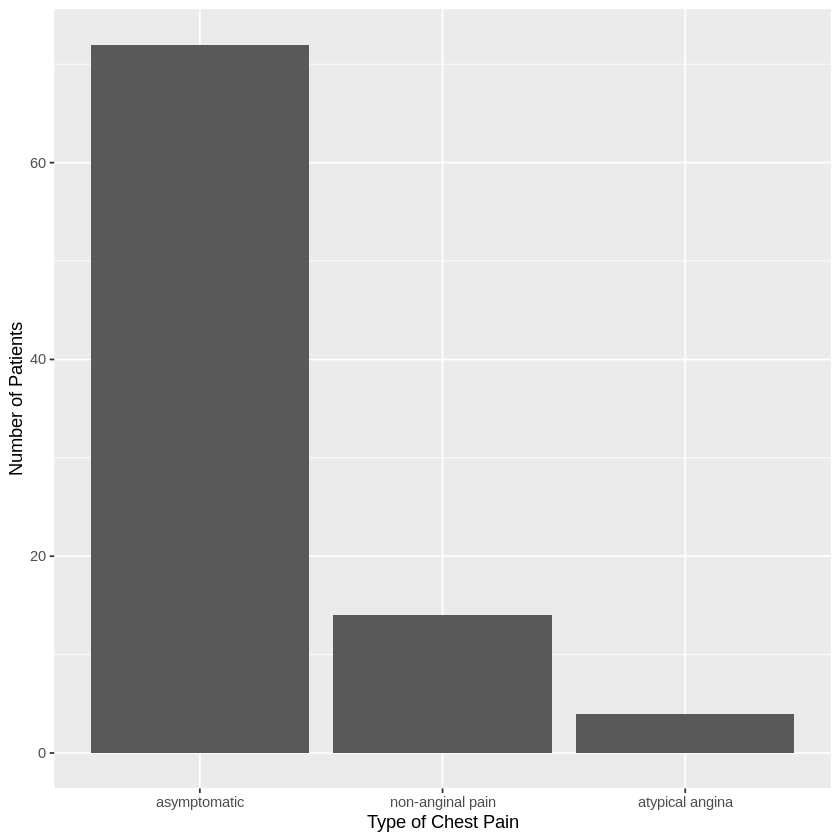

In [7]:
cp_plot <- cp_count |>
    ggplot(aes(x = cp, y = count)) +
                  geom_bar(stat = "identity") + 
                  labs(x = "Type of Chest Pain", y = "Number of Patients")

cp_plot

## Methods

The variables used will be #3 age, #4 sex, #5 painloc (chest pain location), #9 cp (chest pain type), #10 trestbps (resting blood pressure). Using K-NN classification we will design a model that predicts the type of chest pain for a patient based on resting blood pressure, sex, age, and pain type.
We will generate a graph that plots the accuracy of our classification model and then test our model using data from other countries.

## Expected Outcomes and Significance

We expect to find significant correlation levels between chest pain type and the resting blood pressure, age, and sex of the patient. Specifically, we expect to find that typical angina is more common in males and that atypical is more common in females

These findings can be used to discover potential treatments for heart disease and help doctors identify possible early signs of heart disease.

Some future questions could be:
- How do variables such as age and sex impact heart disease?
- What difference in men causes them to have typical angina more than women?
- What difference in women causes them to have atypical angina more than men?